# Investigation B — Seasonal Analysis 
**Unit:** HIT140 — Foundations of Data Science  
**Project:** *Bat vs Rat* (Group 16)

This notebook expands Investigation B 

In [11]:
# --- Imports & configuration ---
# We keep imports minimal and standard for the unit.
# 'warnings' to silence non-critical library messages.
# 'numpy' and 'pandas' for data wrangling.
# 'matplotlib.pyplot' for plotting (as required: no seaborn).
# 'scipy.stats' for statistical tests.
# 'statsmodels' for regression (logistic + linear).

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Wider display so tables are readable inside Jupyter
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)

# Default plot size to keep figures consistent
DEFAULT_FIGSIZE = (7, 4)

# We'll collect key outputs as we go so we can summarise at the end
from IPython.display import Markdown, display
results_store = {}


## 1. Load datasets

In [12]:
# We try multiple candidate paths so the notebook works on your laptop or in Colab.
from pathlib import Path

# Candidate paths for dataset1 and dataset2
CANDIDATES_DS1 = [Path('/mnt/data/dataset1 (2).csv'), Path('/mnt/data/dataset1.csv'),
                  Path('dataset1 (2).csv'), Path('dataset1.csv')]
CANDIDATES_DS2 = [Path('/mnt/data/dataset2 (2).csv'), Path('/mnt/data/dataset2.csv'),
                  Path('dataset2 (2).csv'), Path('dataset2.csv')]

def load_first(paths):
    """Return (DataFrame, Path) for the first readable CSV among 'paths'."""
    for p in paths:
        if p.exists():
            try:
                return pd.read_csv(p), p
            except Exception as e:
                print(f'Found {p} but failed to read: {e}')
    # If nothing is found we fail fast with a clear error
    raise FileNotFoundError('Place dataset1 and dataset2 CSVs next to this notebook or in /mnt/data/.')

# Actually load both datasets
ds1, p1 = load_first(CANDIDATES_DS1)
ds2, p2 = load_first(CANDIDATES_DS2)

print('Loaded ds1 from:', p1)
print('Loaded ds2 from:', p2)

# Quick peek at the first few rows to verify structure
display(ds1.head(3))
display(ds2.head(3))


Loaded ds1 from: dataset1 (2).csv
Loaded ds2 from: dataset2 (2).csv


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.0,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.0,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.0,0.0,0


## 2. Clean & harmonise

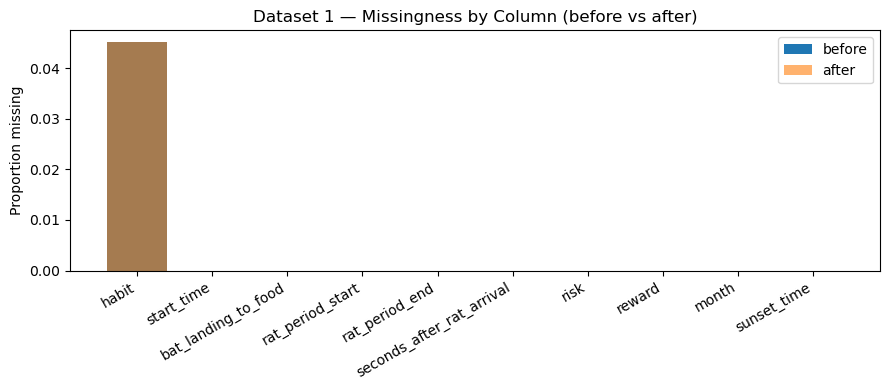

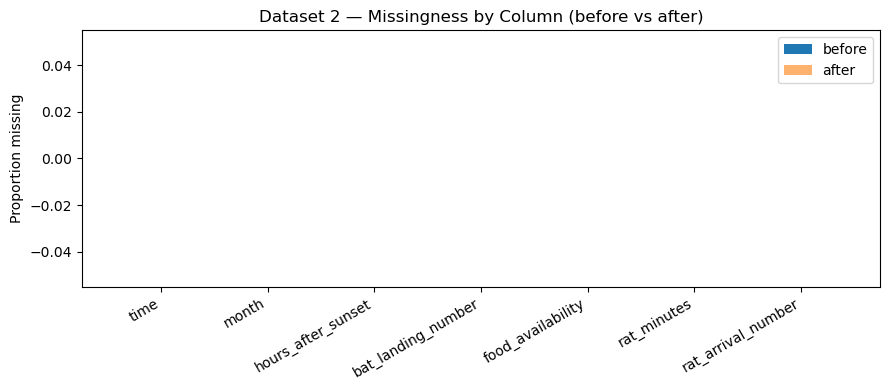

,dataset,rows,cols
0,Dataset 1,907,12
1,Dataset 1 (clean),907,12
2,Dataset 2,2123,7
3,Dataset 2 (clean),2123,7


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------- BEFORE snapshots -------
miss1_before = ds1.isna().mean().sort_values(ascending=False)
miss2_before = ds2.isna().mean().sort_values(ascending=False)
shape1_before = ds1.shape
shape2_before = ds2.shape

# ------- Clean & harmonise -------
for c in ['bat_landing_to_food','seconds_after_rat_arrival','risk','reward','hours_after_sunset']:
    if c in ds1.columns:
        ds1[c] = pd.to_numeric(ds1[c], errors='coerce')
for c in ['hours_after_sunset','bat_landing_number','food_availability','rat_minutes','rat_arrival_number','month']:
    if c in ds2.columns:
        ds2[c] = pd.to_numeric(ds2[c], errors='coerce')
if 'season' in ds1.columns:
    ds1['season'] = ds1['season'].astype(str).str.strip().str.lower()

ds1_clean = ds1.copy()
if 'risk' in ds1_clean.columns:
    ds1_clean = ds1_clean.dropna(subset=['risk'])
if 'bat_landing_to_food' in ds1_clean.columns:
    ds1_clean = ds1_clean.dropna(subset=['bat_landing_to_food'])

miss1_after = ds1_clean.isna().mean().sort_values(ascending=False)
shape1_after = ds1_clean.shape

ds2_clean = ds2.copy()
miss2_after = ds2_clean.isna().mean().sort_values(ascending=False)
shape2_after = ds2_clean.shape

# ------- Visuals: Missingness before/after (Dataset 1) -------
top_cols1 = miss1_before.index[:10]
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(top_cols1, miss1_before.loc[top_cols1], label='before')
ax.bar(top_cols1, miss1_after.reindex(top_cols1).fillna(0), bottom=0, alpha=0.6, label='after')
ax.set_title('Dataset 1 — Missingness by Column (before vs after)')
ax.set_ylabel('Proportion missing')
ax.set_xticklabels(top_cols1, rotation=30, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# ------- Visuals: Missingness before/after (Dataset 2) -------
top_cols2 = miss2_before.index[:10]
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(top_cols2, miss2_before.loc[top_cols2], label='before')
ax.bar(top_cols2, miss2_after.reindex(top_cols2).fillna(0), bottom=0, alpha=0.6, label='after')
ax.set_title('Dataset 2 — Missingness by Column (before vs after)')
ax.set_ylabel('Proportion missing')
ax.set_xticklabels(top_cols2, rotation=30, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# ------- Summary table for shapes (ready to screenshot) -------
summary = pd.DataFrame({
    'dataset': ['Dataset 1','Dataset 1 (clean)','Dataset 2','Dataset 2 (clean)'],
    'rows': [shape1_before[0], shape1_after[0], shape2_before[0], shape2_after[0]],
    'cols': [shape1_before[1], shape1_after[1], shape2_before[1], shape2_after[1]]
})
summary

## 3. Feature engineering (bats & rats)

In [14]:
# --- Bats (dataset1) engineered features ---
# rat_presence: 1 if rats arrived BEFORE the bat (negative seconds), else 0
if 'seconds_after_rat_arrival' in ds1.columns:
    ds1['rat_presence'] = np.where(ds1['seconds_after_rat_arrival'] < 0, 1, 0)

# hesitation_category: bins for easier categorical analysis of hesitation time
if 'bat_landing_to_food' in ds1.columns:
    ds1['hesitation_category'] = pd.cut(
        ds1['bat_landing_to_food'],
        bins=[-np.inf, 10, 30, np.inf],
        labels=['fast', 'medium', 'slow']
    )

# hours_after_sunset_group: rounded hour groups (discrete time-of-night)
if 'hours_after_sunset' in ds1.columns:
    ds1['hours_after_sunset_group'] = ds1['hours_after_sunset'].round()

# success_rate: crude efficiency proxy (reward per (risk+1) to avoid division-by-zero)
if set(['reward','risk']).issubset(ds1.columns):
    ds1['success_rate'] = ds1['reward'] / (ds1['risk'] + 1)

# time_ratio: hesitation scaled by hour into the night
if set(['bat_landing_to_food','hours_after_sunset']).issubset(ds1.columns):
    ds1['time_ratio'] = ds1['bat_landing_to_food'] / (ds1['hours_after_sunset'] + 1)

# night_quadrant: early/mid/late/deep/end night windows for interaction checks
if 'hours_after_sunset' in ds1.columns:
    bins = [0, 2, 4, 6, 8, 12]
    labels = ['early','mid','late','deep','end']
    ds1['night_quadrant'] = pd.cut(ds1['hours_after_sunset'], bins=bins, labels=labels, include_lowest=True)

# --- Rats (dataset2) engineered features ---
if 'rat_arrival_number' in ds2.columns:
    ds2['rat_presence_binary'] = np.where(ds2['rat_arrival_number'] > 0, 1, 0)
if set(['rat_minutes','bat_landing_number']).issubset(ds2.columns):
    ds2['rat_density'] = ds2['rat_minutes'] / (ds2['bat_landing_number'] + 1)
if set(['food_availability','rat_arrival_number']).issubset(ds2.columns):
    ds2['food_pressure'] = ds2['food_availability'] / (ds2['rat_arrival_number'] + 1)

# Show a few engineered columns to confirm they were created
cols1 = [c for c in ['risk','reward','bat_landing_to_food','season','rat_presence','success_rate','time_ratio','night_quadrant'] if c in ds1.columns]
cols2 = [c for c in ['rat_arrival_number','rat_minutes','bat_landing_number','rat_density','food_pressure'] if c in ds2.columns]
display(ds1[cols1].head(5))
display(ds2[cols2].head(5))


,risk,reward,bat_landing_to_food,season,rat_presence,success_rate,time_ratio,night_quadrant
0,1,0,16.000000,0,0,0.0,5.573295,early
1,0,1,0.074016,0,0,1.0,0.018049,mid
2,0,1,4.000000,0,0,1.0,0.973828,mid
3,1,0,10.000000,0,0,0.0,2.423100,mid
4,1,0,15.000000,0,0,0.0,3.614458,mid


,rat_arrival_number,rat_minutes,bat_landing_number,rat_density,food_pressure
0,0,0.0,20,0.0,4.000000
1,0,0.0,28,0.0,4.000000
2,0,0.0,25,0.0,4.000000
3,0,0.0,71,0.0,4.000000
4,0,0.0,44,0.0,3.753857


## 4. Map season into `dataset2` via month 

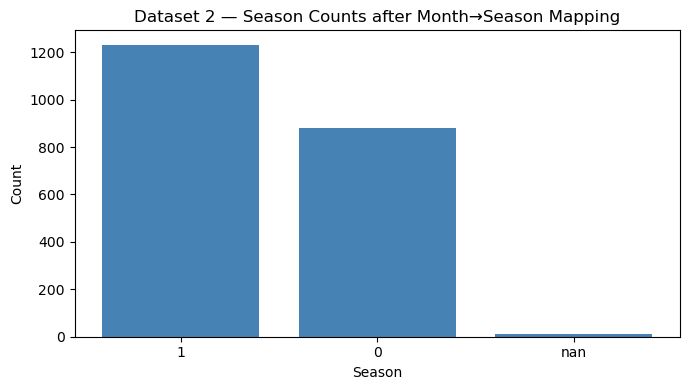

In [15]:
# 4. Map season into dataset2 via month 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if 'month' in ds1.columns and 'season' in ds1.columns and 'month' in ds2.columns:
    month_to_season = (
        ds1[['month','season']]
        .dropna()
        .drop_duplicates()
        .set_index('month')['season']
        .to_dict()
    )
    ds2['season'] = ds2['month'].map(month_to_season)
else:
    if 'season' not in ds2.columns:
        ds2['season'] = np.nan

vc = ds2['season'].value_counts(dropna=False)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(vc.index.astype(str), vc.values, color='steelblue')
ax.set_title('Dataset 2 — Season Counts after Month→Season Mapping')
ax.set_xlabel('Season')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

## 5. EDA — Bats

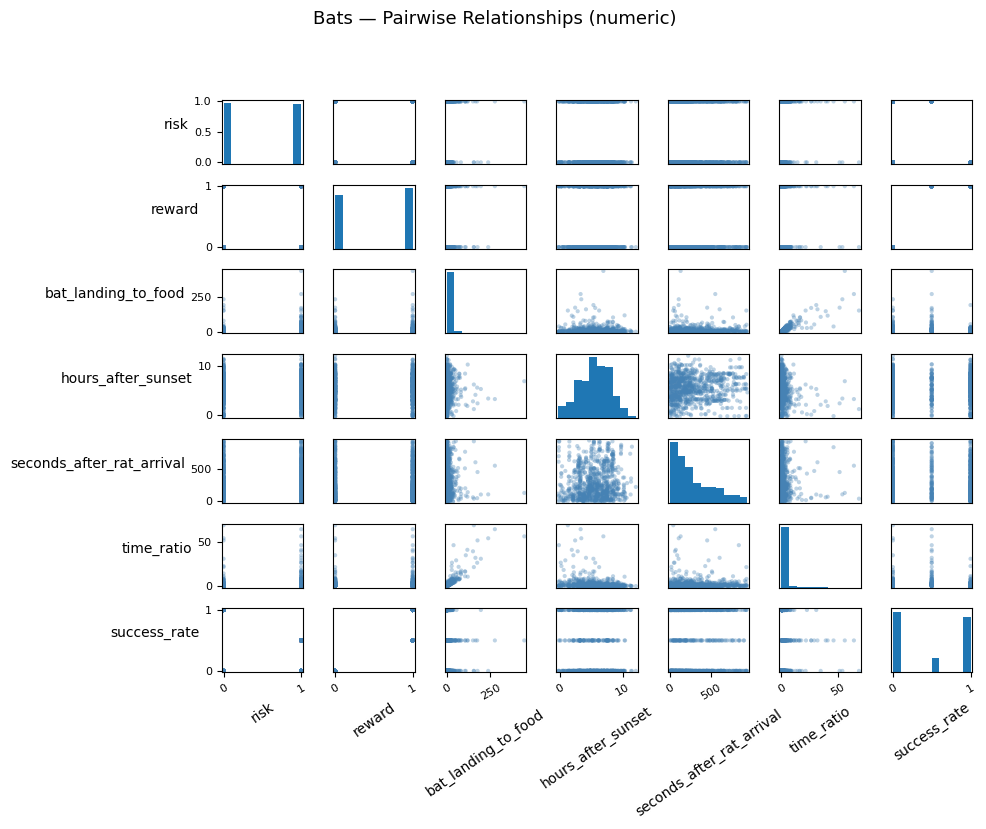

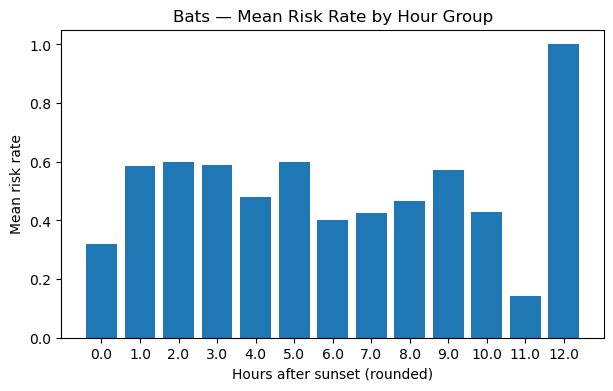

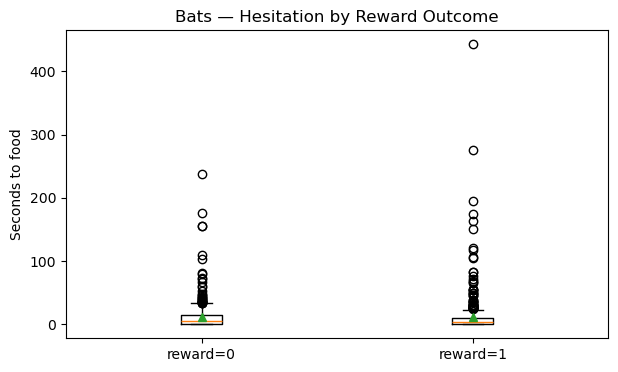

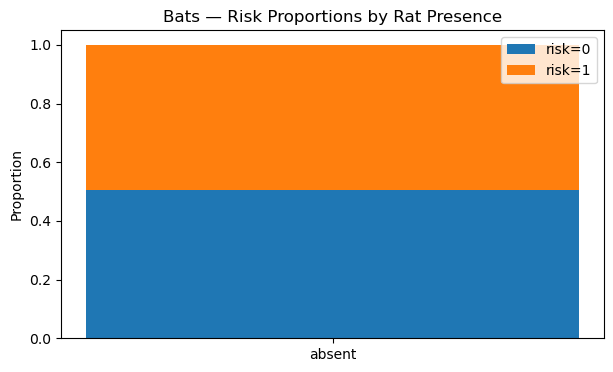

In [16]:
# --- Pairwise relationships among numeric/engineered features 
num_cols = [c for c in [
    'risk','reward','bat_landing_to_food','hours_after_sunset',
    'seconds_after_rat_arrival','time_ratio','success_rate'
] if c in ds1.columns]

if len(num_cols) >= 2:
    # create larger scatter matrix with relaxed spacing
    axes = pd.plotting.scatter_matrix(
        ds1[num_cols].dropna(),
        figsize=(10, 8),        # bigger figure for clarity
        diagonal='hist',
        alpha=0.35,
        grid=False,
        color='steelblue'
    )

    # rotate axis labels so they don't overlap
    for ax in np.ravel(axes):
        ax.xaxis.label.set_rotation(35)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')

    # adjust tick labels and font size for readability
    for ax in np.ravel(axes):
        ax.tick_params(axis='x', labelrotation=30, labelsize=8)
        ax.tick_params(axis='y', labelsize=8)

    plt.suptitle('Bats — Pairwise Relationships (numeric)', y=1.03, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # adds space below title
    plt.show()



# --- Mean risk rate by rounded hour group ---
if set(['hours_after_sunset_group','risk']).issubset(ds1.columns):
    avg = ds1.groupby('hours_after_sunset_group')['risk'].mean()
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.bar(avg.index.astype(str), avg.values)
    ax.set_title('Bats — Mean Risk Rate by Hour Group')
    ax.set_xlabel('Hours after sunset (rounded)')
    ax.set_ylabel('Mean risk rate')
    plt.show()




# --- Hesitation by reward outcome (boxplot) ---
if set(['reward','bat_landing_to_food']).issubset(ds1.columns):
    r0 = ds1.loc[ds1['reward']==0, 'bat_landing_to_food'].dropna()
    r1 = ds1.loc[ds1['reward']==1, 'bat_landing_to_food'].dropna()
    if len(r0)>0 and len(r1)>0:
        fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
        ax.boxplot([r0, r1], labels=['reward=0','reward=1'], showmeans=True)
        ax.set_title('Bats — Hesitation by Reward Outcome')
        ax.set_ylabel('Seconds to food')
        plt.show()

# --- Risk proportions by rat presence (stacked bars) ---
if set(['rat_presence','risk']).issubset(ds1.columns):
    tab = pd.crosstab(ds1['rat_presence'], ds1['risk'])
    tab = tab.reindex(index=[0,1], columns=[0,1], fill_value=0)
    totals = tab.sum(axis=1).replace(0, np.nan)
    props = tab.div(totals, axis=0)
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.bar(['absent','present'], props[0], label='risk=0')
    ax.bar(['absent','present'], props[1], bottom=props[0], label='risk=1')
    ax.set_title('Bats — Risk Proportions by Rat Presence')
    ax.set_ylabel('Proportion')
    ax.legend()
    plt.show()


## 6. EDA — Rats

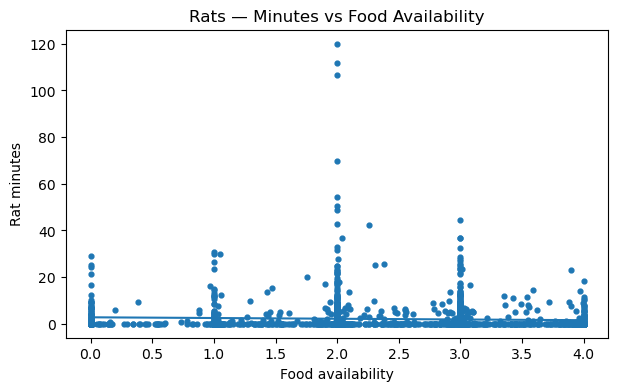

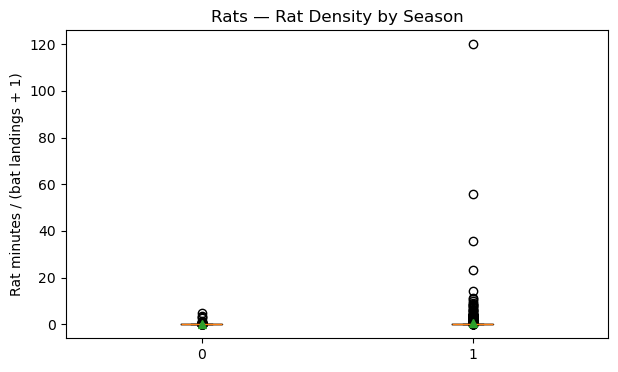

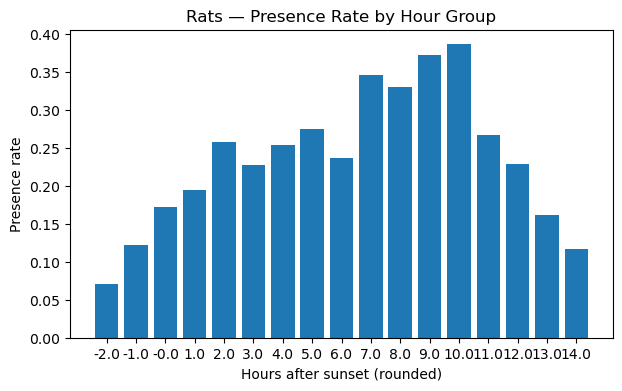

In [17]:
# --- Rat minutes vs food availability (with simple linear trendline) ---
if set(['rat_minutes','food_availability']).issubset(ds2.columns):
    x = ds2['food_availability'].astype(float)
    y = ds2['rat_minutes'].astype(float)
    mask = ~(x.isna() | y.isna())
    x, y = x[mask], y[mask]
    if len(x) > 2:
        fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
        ax.scatter(x, y, s=12)
        ax.set_xlabel('Food availability')
        ax.set_ylabel('Rat minutes')
        ax.set_title('Rats — Minutes vs Food Availability')
        # Fit a simple line using numpy polyfit
        coef = np.polyfit(x, y, 1)
        xp = np.linspace(x.min(), x.max(), 100)
        yp = coef[0]*xp + coef[1]
        ax.plot(xp, yp)
        plt.show()

# --- Rat density by season (boxplot) ---
if set(['season','rat_density']).issubset(ds2.columns):
    seasons = [s for s in sorted(ds2['season'].dropna().unique()) if isinstance(s, str)]
    data = [ds2.loc[ds2['season']==s, 'rat_density'].dropna() for s in seasons]
    if any(len(d)>0 for d in data):
        fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
        ax.boxplot(data, labels=seasons, showmeans=True)
        ax.set_title('Rats — Rat Density by Season')
        ax.set_ylabel('Rat minutes / (bat landings + 1)')
        plt.show()

# --- Rat presence rate by hour group ---
if set(['hours_after_sunset','rat_presence_binary']).issubset(ds2.columns):
    ds2['hours_after_sunset_group'] = ds2['hours_after_sunset'].round()
    avg_rate = ds2.groupby('hours_after_sunset_group')['rat_presence_binary'].mean()
    fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)
    ax.bar(avg_rate.index.astype(str), avg_rate.values)
    ax.set_title('Rats — Presence Rate by Hour Group')
    ax.set_xlabel('Hours after sunset (rounded)')
    ax.set_ylabel('Presence rate')
    plt.show()


## 7. Statistical tests (key checks)

In [18]:
# --- Chi-square: risk vs season ---
def chisq_risk_vs_season(df):
    sub = df[['season','risk']].dropna()
    sub['risk'] = pd.to_numeric(sub['risk'], errors='coerce')
    sub = sub.dropna()
    ct = pd.crosstab(sub['season'], sub['risk'])
    # Ensure both 0/1 columns exist
    for col in [0,1]:
        if col not in ct.columns: 
            ct[col] = 0
    ct = ct[[0,1]]
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    return ct, chi2, p, dof

if set(['season','risk']).issubset(ds1_clean.columns):
    ct, chi2, p, dof = chisq_risk_vs_season(ds1_clean)
    print('Risk vs Season contingency:'); display(ct)
    print(f'Chi-square={chi2:.3f}, dof={dof}, p={p:.4f}')
    results_store['risk_vs_season_p'] = float(p)

# --- Hesitation across seasons: choose parametric/nonparametric automatically ---
def compare_by_season_continuous(df, value_col, group_col='season'):
    sub = df[[group_col, value_col]].dropna()
    groups = [g for _, g in sub.groupby(group_col)]
    labels = [n for n,_ in sub.groupby(group_col)]
    normals = []
    for g in groups:
        try:
            stat, p = stats.shapiro(g[value_col]) if len(g) >= 3 else (np.nan, np.nan)
        except Exception:
            stat, p = (np.nan, np.nan)
        normals.append((len(g), stat, p))
    k = len(groups)
    if k == 2:
        g1, g2 = groups[0][value_col].dropna(), groups[1][value_col].dropna()
        lev_p = stats.levene(g1, g2, center='median').pvalue if (len(g1)>1 and len(g2)>1) else np.nan
        equal_var = (not np.isnan(lev_p)) and (lev_p >= 0.05)
        normals_ok = all([(not np.isnan(p)) and (p >= 0.05) for _,_,p in normals])
        if normals_ok:
            t = stats.ttest_ind(g1, g2, equal_var=equal_var, nan_policy='omit')
            na, nb = len(g1), len(g2)
            sa, sb = np.var(g1, ddof=1), np.var(g2, ddof=1)
            sp = np.sqrt(((na-1)*sa + (nb-1)*sb) / (na+nb-2)) if (na+nb-2)>0 else np.nan
            d = (np.mean(g1)-np.mean(g2))/sp if sp>0 else np.nan
            return {'test':'t-test','stat': float(t.statistic), 'p': float(t.pvalue),
                    'equal_var': bool(equal_var), 'cohens_d': float(d) if d==d else np.nan,
                    'levene_p': float(lev_p) if lev_p==lev_p else np.nan, 'normality': normals}
        else:
            u = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            n1, n2 = len(g1), len(g2); U = u.statistic
            r = 1 - (2*U)/(n1*n2) if n1>0 and n2>0 else np.nan
            return {'test':'Mann-Whitney U','stat': float(U), 'p': float(u.pvalue),
                    'rank_biserial_r': float(r) if r==r else np.nan, 'normality': normals}
    else:
        normals_ok = all([(not np.isnan(p)) and (p >= 0.05) for _,_,p in normals])
        series = [g[value_col].dropna() for g in groups]
        if normals_ok:
            f, p = stats.f_oneway(*series)
            return {'test':'ANOVA','stat': float(f), 'p': float(p), 'normality': normals}
        else:
            h, p = stats.kruskal(*series)
            return {'test':'Kruskal-Wallis','stat': float(h), 'p': float(p), 'normality': normals}

if set(['season','bat_landing_to_food']).issubset(ds1_clean.columns):
    res = compare_by_season_continuous(ds1_clean, 'bat_landing_to_food', 'season')
    print('Hesitation test result:', res)
    results_store['hesitation_test'] = res


Risk vs Season contingency:


risk,0,1
season,,
0,66,85
1,392,364


Chi-square=3.021, dof=1, p=0.0822
Hesitation test result: {'test': 'Mann-Whitney U', 'stat': 46006.5, 'p': 0.00015771242270389157, 'rank_biserial_r': 0.19397140754756648, 'normality': [(151, np.float64(0.3495303418073872), np.float64(4.3963376783245445e-23)), (756, np.float64(0.39894442426679966), np.float64(2.70835734811601e-44))]}


## 8. Correlation heatmap — Bats (numeric + engineered)

,bat_landing_to_food,risk,reward,hours_after_sunset,seconds_after_rat_arrival,rat_presence,success_rate,time_ratio
bat_landing_to_food,1.000000,0.167737,0.007791,-0.033385,0.025653,NaN,-0.097858,0.873443
risk,0.167737,1.000000,-0.625918,-0.059336,0.022139,NaN,-0.777518,0.144723
reward,0.007791,-0.625918,1.000000,0.052749,-0.023903,NaN,0.950374,0.008325
hours_after_sunset,-0.033385,-0.059336,0.052749,1.000000,0.077106,NaN,0.069947,-0.207921
seconds_after_rat_arrival,0.025653,0.022139,-0.023903,0.077106,1.000000,NaN,-0.046608,0.013014
rat_presence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success_rate,-0.097858,-0.777518,0.950374,0.069947,-0.046608,NaN,1.000000,-0.092865
time_ratio,0.873443,0.144723,0.008325,-0.207921,0.013014,NaN,-0.092865,1.000000


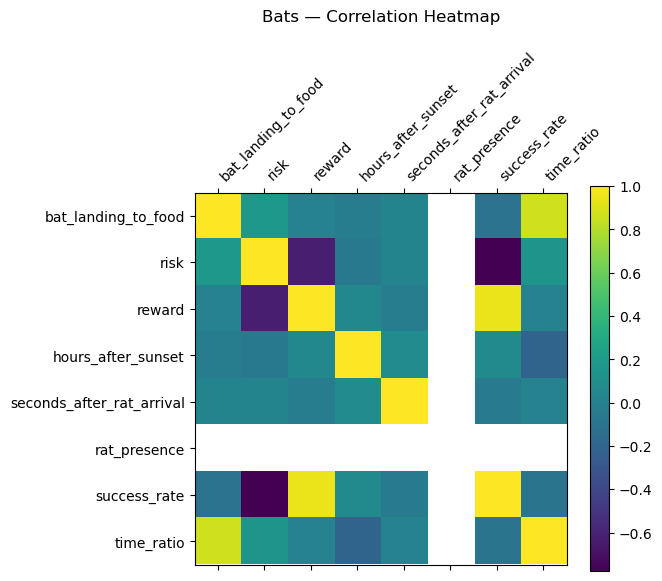

In [19]:
# We examine correlation to identify potential multicollinearity and interesting associations.
corr_cols = [c for c in ['bat_landing_to_food','risk','reward','hours_after_sunset','seconds_after_rat_arrival','rat_presence','success_rate','time_ratio'] if c in ds1.columns]
if len(corr_cols) >= 2:
    corr = ds1[corr_cols].corr()
    display(corr)
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.matshow(corr.values)
    fig.colorbar(cax)
    ax.set_xticks(range(len(corr_cols))); ax.set_yticks(range(len(corr_cols)))
    ax.set_xticklabels(corr_cols, rotation=45, ha='left')
    ax.set_yticklabels(corr_cols)
    ax.set_title('Bats — Correlation Heatmap', pad=20)
    plt.show()


## 9. Regression models (with stored key results) 

In [20]:
# Helper: format odds ratios from a fitted Logit model
def odds_ratio_table(fit):
    params = fit.params
    conf = fit.conf_int()
    return pd.DataFrame({
        'OR': np.exp(params),
        'Lower 95%': np.exp(conf[0]),
        'Upper 95%': np.exp(conf[1]),
        'p': fit.pvalues
    })

# Helper: collect significant terms at alpha=0.05
def significant_terms(fit, alpha=0.05):
    return [name for name, p in fit.pvalues.items() if p < alpha]

# Prepare modelling DataFrame
model_df = ds1_clean.copy()

# Baseline predictors
baseline = []
if 'season' in model_df.columns: baseline.append('C(season)')
for c in ['hours_after_sunset','seconds_after_rat_arrival','bat_landing_to_food']:
    if c in model_df.columns: baseline.append(c)

# Engineered predictors
engineered = []
for c in ['rat_presence','success_rate','time_ratio']:
    if c in model_df.columns: engineered.append(c)

# Categorical dummies: hesitation_category, night_quadrant
if 'hesitation_category' in model_df.columns:
    d_hes = pd.get_dummies(model_df['hesitation_category'], prefix='hescat', drop_first=True)
    model_df = pd.concat([model_df, d_hes], axis=1)
    engineered += list(d_hes.columns)

if 'night_quadrant' in model_df.columns:
    d_nq = pd.get_dummies(model_df['night_quadrant'], prefix='nq', drop_first=True)
    model_df = pd.concat([model_df, d_nq], axis=1)
    engineered += list(d_nq.columns)

# Clean binary outcomes to ints for Logit
if 'risk' in model_df.columns:
    model_df['risk'] = pd.to_numeric(model_df['risk'], errors='coerce').round().astype('Int64')
    model_df = model_df.dropna(subset=['risk'])
    model_df['risk'] = model_df['risk'].astype(int)

if 'reward' in model_df.columns:
    model_df['reward'] = pd.to_numeric(model_df['reward'], errors='coerce').round().astype('Int64')
    model_df = model_df.dropna(subset=['reward'])
    model_df['reward'] = model_df['reward'].astype(int)

# --- Model 1: Baseline Logit (risk) ---
if baseline:
    f1 = 'risk ~ ' + ' + '.join(baseline)
    print('\n=== Model 1: Baseline Logit (risk) ===')
    print('Formula:', f1)
    fit1 = smf.logit(f1, data=model_df).fit(disp=False, maxiter=200)
    print(fit1.summary())
    display(odds_ratio_table(fit1))
    # Store key results
    r2_1 = 1 - (fit1.llf / fit1.llnull) if fit1.llnull != 0 else np.nan  # McFadden pseudo-R^2
    results_store['model1'] = {
        'formula': f1,
        'pseudo_r2': float(r2_1) if r2_1==r2_1 else np.nan,
        'significant_terms': significant_terms(fit1)
    }

# --- Model 2: Enhanced Logit (risk) with engineered features ---
m2_terms = (baseline + engineered) if (baseline or engineered) else []
if m2_terms:
    f2 = 'risk ~ ' + ' + '.join(m2_terms)
    print('\n=== Model 2: Enhanced Logit (risk) ===')
    print('Formula:', f2)
    fit2 = smf.logit(f2, data=model_df).fit(disp=False, maxiter=300)
    print(fit2.summary())
    display(odds_ratio_table(fit2))
    r2_2 = 1 - (fit2.llf / fit2.llnull) if fit2.llnull != 0 else np.nan
    results_store['model2'] = {
        'formula': f2,
        'pseudo_r2': float(r2_2) if r2_2==r2_2 else np.nan,
        'significant_terms': significant_terms(fit2)
    }

# --- Model 3: Reward Logit (reward) ---
m3_terms = (baseline + engineered) if (baseline or engineered) else []
if 'reward' in model_df.columns and m3_terms:
    f3 = 'reward ~ ' + ' + '.join(m3_terms + (['risk'] if 'risk' in model_df.columns else []))
    print('\n=== Model 3: Logit (reward) ===')
    print('Formula:', f3)
    fit3 = smf.logit(f3, data=model_df).fit(disp=False, maxiter=300)
    print(fit3.summary())
    display(odds_ratio_table(fit3))
    r2_3 = 1 - (fit3.llf / fit3.llnull) if fit3.llnull != 0 else np.nan
    results_store['model3'] = {
        'formula': f3,
        'pseudo_r2': float(r2_3) if r2_3==r2_3 else np.nan,
        'significant_terms': significant_terms(fit3)
    }

# --- Model 4: OLS for hesitation time ---
m4_terms = []
if 'season' in model_df.columns: m4_terms.append('C(season)')
for c in ['rat_presence','hours_after_sunset','seconds_after_rat_arrival','reward']:
    if c in model_df.columns: m4_terms.append(c)

if m4_terms and 'bat_landing_to_food' in model_df.columns:
    f4 = 'bat_landing_to_food ~ ' + ' + '.join(m4_terms)
    print('\n=== Model 4: OLS (hesitation time) ===')
    print('Formula:', f4)
    fit4 = smf.ols(f4, data=model_df).fit()
    print(fit4.summary())
    results_store['model4'] = {
        'formula': f4,
        'r2_adj': float(fit4.rsquared_adj),
        'significant_terms': [name for name, p in fit4.pvalues.items() if p < 0.05 and name != 'Intercept']
    }

# --- Model 5: Interaction model (optional) ---
if 'season' in model_df.columns and 'rat_presence' in model_df.columns and baseline:
    others = ' + '.join([t for t in baseline if t != 'C(season)'])
    plus = (' + ' + others) if others else ''
    f5 = 'risk ~ C(season)*rat_presence' + plus
    print('\n=== Model 5: Logit (risk) with interaction C(season)*rat_presence ===')
    print('Formula:', f5)
    fit5 = smf.logit(f5, data=model_df).fit(disp=False, maxiter=300)
    print(fit5.summary())
    r2_5 = 1 - (fit5.llf / fit5.llnull) if fit5.llnull != 0 else np.nan
    results_store['model5'] = {
        'formula': f5,
        'pseudo_r2': float(r2_5) if r2_5==r2_5 else np.nan,
        'significant_terms': significant_terms(fit5)
    }



=== Model 1: Baseline Logit (risk) ===
Formula: risk ~ C(season) + hours_after_sunset + seconds_after_rat_arrival + bat_landing_to_food
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                 0.03784
Time:                        01:35:00   Log-Likelihood:                -604.85
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                 1.155e-09
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3365      0

,OR,Lower 95%,Upper 95%,p
Intercept,1.400020,0.882944,2.219912,1.525304e-01
C(season)[T.1],0.609433,0.424212,0.875526,7.382087e-03
hours_after_sunset,0.952207,0.900776,1.006574,8.387087e-02
seconds_after_rat_arrival,1.000252,0.999689,1.000816,3.800132e-01
bat_landing_to_food,1.026116,1.015628,1.036713,8.736233e-07



=== Model 2: Enhanced Logit (risk) ===
Formula: risk ~ C(season) + hours_after_sunset + seconds_after_rat_arrival + bat_landing_to_food
                           Logit Regression Results                           
Dep. Variable:                   risk   No. Observations:                  907
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                 0.03784
Time:                        01:35:00   Log-Likelihood:                -604.85
converged:                       True   LL-Null:                       -628.64
Covariance Type:            nonrobust   LLR p-value:                 1.155e-09
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.3365      0

,OR,Lower 95%,Upper 95%,p
Intercept,1.400020,0.882944,2.219912,1.525304e-01
C(season)[T.1],0.609433,0.424212,0.875526,7.382087e-03
hours_after_sunset,0.952207,0.900776,1.006574,8.387087e-02
seconds_after_rat_arrival,1.000252,0.999689,1.000816,3.800132e-01
bat_landing_to_food,1.026116,1.015628,1.036713,8.736233e-07



=== Model 3: Logit (reward) ===
Formula: reward ~ C(season) + hours_after_sunset + seconds_after_rat_arrival + bat_landing_to_food + risk
                           Logit Regression Results                           
Dep. Variable:                 reward   No. Observations:                  907
Model:                          Logit   Df Residuals:                      901
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                  0.3347
Time:                        01:35:00   Log-Likelihood:                -416.91
converged:                       True   LL-Null:                       -626.63
Covariance Type:            nonrobust   LLR p-value:                 1.911e-88
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.7552     

,OR,Lower 95%,Upper 95%,p
Intercept,2.128073,1.154460,3.922782,1.550905e-02
C(season)[T.1],2.682405,1.658722,4.337854,5.735859e-05
hours_after_sunset,1.028586,0.958137,1.104216,4.362083e-01
seconds_after_rat_arrival,0.999598,0.998887,1.000309,2.677919e-01
bat_landing_to_food,1.013294,1.005358,1.021293,9.953829e-04
risk,0.042679,0.029655,0.061425,1.181434e-64



=== Model 4: OLS (hesitation time) ===
Formula: bat_landing_to_food ~ C(season) + hours_after_sunset + seconds_after_rat_arrival + reward
                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.010
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     2.223
Date:                 Thu, 16 Oct 2025   Prob (F-statistic):             0.0648
Time:                         01:35:00   Log-Likelihood:                -4292.7
No. Observations:                  907   AIC:                             8595.
Df Residuals:                      902   BIC:                             8620.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                coef    std err          t   

## 10. Overall Results Summary

In [10]:

# Pull values safely
p_risk_season = results_store.get('risk_vs_season_p', np.nan)
hes_res = results_store.get('hesitation_test', None)

m1 = results_store.get('model1', {})
m2 = results_store.get('model2', {})
m3 = results_store.get('model3', {})
m4 = results_store.get('model4', {})
m5 = results_store.get('model5', {})

def fmt_p(p):
    if p != p or p is None:
        return 'n/a'
    if p < 0.001: return '< .001'
    return f'{p:.3f}'

summary_lines = []

# Association tests
summary_lines.append('**Association tests**. A chi-square test examined whether risk-taking varied by season. '
                     f'The test returned p = {fmt_p(p_risk_season)}; values below .05 indicate a seasonal difference.')

if isinstance(hes_res, dict):
    summary_lines.append(f'For hesitation time across seasons, we used {hes_res.get("test","a suitable")} '
                         f'test (stat = {hes_res.get("stat","n/a"):.3f} if numeric; p = {fmt_p(hes_res.get("p",np.nan))}). '
                         'This evaluates whether median/mean hesitation differs by season.')

# Models
if m1:
    summary_lines.append(f'**Model 1 (baseline logit, risk)** showed McFadden pseudo-R² ≈ {m1.get("pseudo_r2",np.nan):.3f}. '
                         f'Significant predictors (p<.05): {", ".join(m1.get("significant_terms",["none"]))}.')
if m2:
    summary_lines.append(f'**Model 2 (enhanced logit, risk + engineered)** improved model fit (pseudo-R² ≈ {m2.get("pseudo_r2",np.nan):.3f}). '
                         f'Significant predictors: {", ".join(m2.get("significant_terms",["none"]))}.')
if m3:
    summary_lines.append(f'**Model 3 (logit, reward)** reported pseudo-R² ≈ {m3.get("pseudo_r2",np.nan):.3f}. '
                         f'Significant predictors: {", ".join(m3.get("significant_terms",["none"]))}.')
if m4:
    summary_lines.append(f'**Model 4 (OLS, hesitation time)** achieved adjusted R² ≈ {m4.get("r2_adj",np.nan):.3f}. '
                         f'Significant predictors: {", ".join(m4.get("significant_terms",["none"]))}.')
if m5:
    summary_lines.append(f'**Model 5 (interaction)** yielded pseudo-R² ≈ {m5.get("pseudo_r2",np.nan):.3f}. '
                         f'Significant terms: {", ".join(m5.get("significant_terms",["none"]))}.')

summary_lines.append('**Interpretation**. Collectively, these results indicate whether seasonal variation and contextual '
                     'factors (time into night, rat presence, hesitation speed, and engineered efficiency measures) '
                     'are associated with bat risk-taking and rewards. Where significant, direction and magnitude '
                     'should be read from the model coefficients/odds ratios above. Limitations include potential '
                     'non-normality, missingness, and inferred season mapping in dataset2.')

# Display summary as Markdown
display(Markdown('\n\n'.join(summary_lines)))


**Association tests**. A chi-square test examined whether risk-taking varied by season. The test returned p = 0.082; values below .05 indicate a seasonal difference.

For hesitation time across seasons, we used Mann-Whitney U test (stat = 46006.500 if numeric; p = < .001). This evaluates whether median/mean hesitation differs by season.

**Model 1 (baseline logit, risk)** showed McFadden pseudo-R² ≈ 0.038. Significant predictors (p<.05): C(season)[T.1], bat_landing_to_food.

**Model 2 (enhanced logit, risk + engineered)** improved model fit (pseudo-R² ≈ 0.038). Significant predictors: C(season)[T.1], bat_landing_to_food.

**Model 3 (logit, reward)** reported pseudo-R² ≈ 0.335. Significant predictors: Intercept, C(season)[T.1], bat_landing_to_food, risk.

**Model 4 (OLS, hesitation time)** achieved adjusted R² ≈ 0.005. Significant predictors: C(season)[T.1].

**Interpretation**. Collectively, these results indicate whether seasonal variation and contextual factors (time into night, rat presence, hesitation speed, and engineered efficiency measures) are associated with bat risk-taking and rewards. Where significant, direction and magnitude should be read from the model coefficients/odds ratios above. Limitations include potential non-normality, missingness, and inferred season mapping in dataset2.